Copyright (c) 2017-2020 [Serpent-Tools developer team](https://github.com/CORE-GATECH-GROUP/serpent-tools/graphs/contributors), GTRC

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# DetectorReader

## Basic Operation
This notebook details how to utilize the [`serpentTools`](https://github.com/CORE-GATECH-GROUP/serpent-tools) package for reading detector files, `[input]_det[N].m` produced by SERPENT [1]. 
Detectors can be defined with many binning parameters, listed [on the SERPENT Wiki](http://serpent.vtt.fi/mediawiki/index.php/Input_syntax_manual#det_.28detector_definition.29). 
One could define a detector that has a spatial mesh, `dx/dy/dz/`, but also includes reaction and material bins, `dr, dm`. 
Detectors are stored on the reader object in the ``detectors`` dictionary as custom ``Detector`` objects. Here, all energy and spatial grid data are stored, including other binning information such as reaction, universe, and lattice bins. 

In [1]:
%matplotlib inline
from matplotlib import pyplot
import serpentTools

In [2]:
pinFile = 'fuelPin_det0.m'
bwrFile = 'bwr_det0.m'
pin = serpentTools.readDataFile(pinFile)
bwr = serpentTools.readDataFile(bwrFile)

In [3]:
print(pin.detectors)
print(bwr.detectors)

{'nodeFlx': <serpentTools.detectors.Detector object at 0x7ff3903f1df0>}
{'xymesh': <serpentTools.detectors.CartesianDetector object at 0x7ff3903f17c0>, 'spectrum': <serpentTools.detectors.Detector object at 0x7ff372dfc0a0>}


These detectors were defined for a single fuel pin with 16 axial layers and a BWR assembly, with a description of the detectors provided in the output:

|Name| Description|
|----|------------|
|`nodeFlx`| One-group flux tallied in each axial layer |
|`spectrum`|CSEWG 239 group structure for flux and U-235 fission cross section|
|`xymesh`|Two-group flux for a 20x20 xy grid|

For each `Detector` object, the full tally matrix from the file is stored in the `bins` array.

In [4]:
nodeFlx = pin.detectors['nodeFlx']
print(nodeFlx.bins.shape)
nodeFlx.bins[:3,:].T

(16, 12)


array([[1.00000e+00, 2.00000e+00, 3.00000e+00],
       [1.00000e+00, 1.00000e+00, 1.00000e+00],
       [1.00000e+00, 2.00000e+00, 3.00000e+00],
       [1.00000e+00, 1.00000e+00, 1.00000e+00],
       [1.00000e+00, 1.00000e+00, 1.00000e+00],
       [1.00000e+00, 1.00000e+00, 1.00000e+00],
       [1.00000e+00, 1.00000e+00, 1.00000e+00],
       [1.00000e+00, 1.00000e+00, 1.00000e+00],
       [1.00000e+00, 1.00000e+00, 1.00000e+00],
       [1.00000e+00, 1.00000e+00, 1.00000e+00],
       [2.34759e-02, 5.75300e-02, 8.47000e-02],
       [4.53000e-03, 3.38000e-03, 2.95000e-03]])

Here, only three columns, shown as rows for readability, are changing: 

* column 0: universe column
* column 10: tally column
* column 11: errors

Detectors can also be obtained by indexing into the reader object, as

In [5]:
pin['nodeFlx']

In [7]:
bwr.get('spectrum')

Tally data is reshaped corresponding to the bin information provided by Serpent. The tally and error columns are recast into multi-dimensional arrays where each dimension is some unique bin type like energy or spatial bin index. For this case, since the only variable bin quantity is that of the changing universe, the ``tallies`` and ``errors`` attributes will be 1D arrays.

In [9]:
assert nodeFlx.tallies.shape == (16, )
assert nodeFlx.errors.shape == (16, )
nodeFlx.tallies

array([0.0234759 , 0.05753   , 0.0847    , 0.102034  , 0.110384  ,
       0.110174  , 0.102934  , 0.0928861 , 0.0810541 , 0.067961  ,
       0.0550446 , 0.0422486 , 0.0310226 , 0.0211475 , 0.0125272 ,
       0.00487726])

In [10]:
nodeFlx.errors

array([0.00453, 0.00338, 0.00295, 0.00263, 0.00231, 0.00222, 0.00238,
       0.00251, 0.00282, 0.00307, 0.00359, 0.00415, 0.00511, 0.00687,
       0.00809, 0.01002])

Note: Python and numpy arrays are zero-indexed, meaning the first item is accessed with `array[0]`, rather than `array[1]`.

Bin information is retained through the ``indexes`` attribute. Each entry indicates what bin type is changing along that dimension of ``tallies`` and ``errors``. Here, ``universe`` is the first item and indicates that the first dimension of ``tallies`` corresponds to a changing universe bin.

In [11]:
nodeFlx.indexes

('universe',)

For detectors that include some grid matrices, such as spatial or energy meshes `DET<name>E`, these arrays are stored in the `grids` dictionary

In [12]:
spectrum = bwr.detectors['spectrum']
print(spectrum.grids['E'][:5, :])

[[1.00002e-11 4.13994e-07 2.07002e-07]
 [4.13994e-07 5.31579e-07 4.72786e-07]
 [5.31579e-07 6.25062e-07 5.78320e-07]
 [6.25062e-07 6.82560e-07 6.53811e-07]
 [6.82560e-07 8.33681e-07 7.58121e-07]]


## Multi-dimensional Detectors

The `Detector` objects are capable of reshaping the detector data into an array where each axis corresponds to a varying bin. In the above examples, the reshaped data was one-dimensional, because the detectors only tallied data against one bin, universe and energy. In the following example, the detector has been configured to tally the fission and capture rates (two `dr` arguments) in an XY mesh.

In [13]:
xy = bwr.detectors['xymesh']
xy.indexes

('energy', 'ymesh', 'xmesh')

Traversing the first axis in the `tallies` array corresponds to changing the value of the `energy`. The second axis corresponds to changing `ymesh` values, and the final axis reflects changes in `xmesh`.

In [14]:
print(xy.bins.shape)
print(xy.tallies.shape)
print(xy.bins[:5, 10])
print(xy.tallies[0, 0, :5])

(800, 12)
(2, 20, 20)
[8.19312e+17 7.18519e+17 6.90079e+17 6.22241e+17 5.97257e+17]
[8.19312e+17 7.18519e+17 6.90079e+17 6.22241e+17 5.97257e+17]


### Slicing
As the detectors produced by SERPENT can contain multiple bin types, obtaining data from the tally data can become complicated. This retrieval can be simplified using the `slice` method. This method takes an argument indicating what bins (keys in `indexes`) to fix at what position.

If we want to retrieve the tally data for the capture reaction in the `spectrum` detector, you would instruct the `slice` method to use column 1 along the axis that corresponds to the reaction bin, as the fission reaction corresponded to reaction tally 2 in the original matrix. Since python and numpy arrays are zero indexed, the second reaction tally is stored in column 1.

In [15]:
spectrum.slice({'reaction': 1})[:20]

array([3.66341e+22, 6.53587e+20, 3.01655e+20, 1.51335e+20, 3.14546e+20,
       7.45742e+19, 4.73387e+20, 2.82554e+20, 9.89379e+19, 9.49670e+19,
       8.98272e+19, 2.04606e+20, 3.58272e+19, 1.44708e+20, 7.25499e+19,
       6.31722e+20, 2.89445e+20, 2.15484e+20, 3.59303e+20, 3.15000e+20])

This method also works for slicing the error, or score, matrix

In [16]:
spectrum.slice({'reaction': 1}, 'errors')[:20]

array([0.00692, 0.01136, 0.01679, 0.02262, 0.01537, 0.02915, 0.01456,
       0.01597, 0.01439, 0.01461, 0.01634, 0.01336, 0.01549, 0.01958,
       0.02165, 0.0192 , 0.02048, 0.01715, 0.02055, 0.0153 ])

## Plotting Routines

Each `Detector` object is capable of simple 1D and 2D plotting routines. 
The simplest 1D plot method is simply `plot`, however a wide range of plot options are present.

|Option|Description|
|-|-|
|`what`|What data to plot|
|`ax`|Preprepared figure on which to add this plot|
|`xdim`|Quantity from `indexes` to use as x-axis|
|`sigma`|Confidence interval to place on errors - 1D|
|`steps`|Draw tally values as constant inside bin - 1D|
|`xlabel`|Label to apply to x-axis|
|`ylabel`|Label to apply to y-axis|
|`loglog`|Use a log scalling on both of the axes|
|`logx`|Use a log scaling on the x-axis|
|`logy`|Use a log scaling on the y-axis|
|`legend`|Place a legend on the figure|
|`ncol`|Number of columns to apply to the legend|

The plot routine also accepts various options, which can be found in the [matplotlib.pyplot.plot documentation](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html)

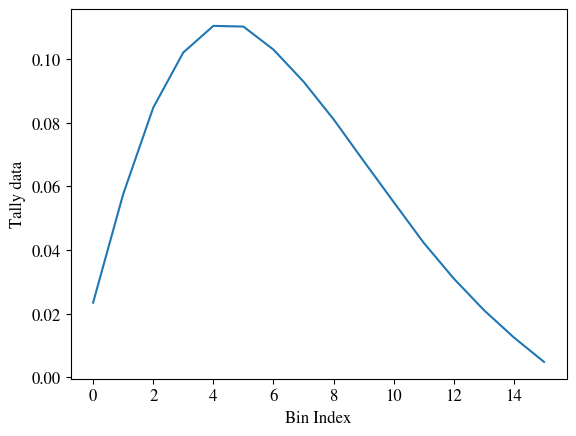

In [17]:
nodeFlx.plot();

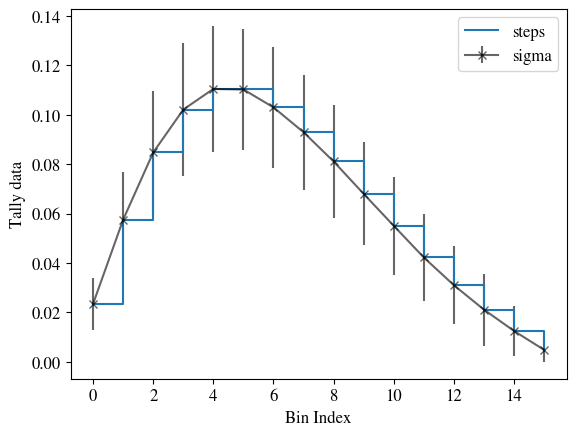

In [18]:
ax = nodeFlx.plot(steps=True, label='steps')
ax = nodeFlx.plot(sigma=100, ax=ax, c='k', alpha=0.6, marker='x', label='sigma')

Passing `what='errors'` to the plot method plots the associated relative errors, rather than the tally data on the y-axis. 
Similarly, passing a key from `indexes` sets the x-axis to be that specific index.

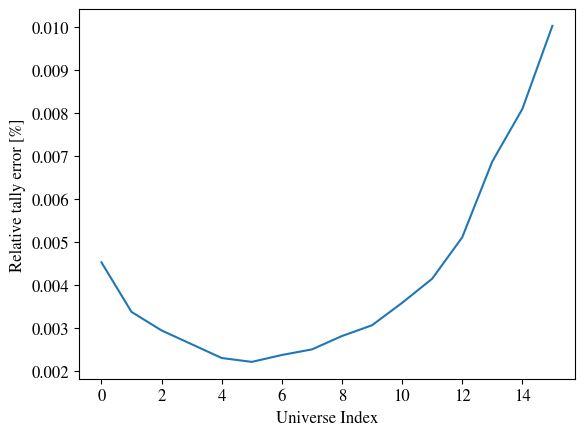

In [19]:
nodeFlx.plot(xdim='universe', what='errors', 
                        ylabel='Relative tally error [%]');

### Mesh Plots
For data with dimensionality greater than one, the `meshPlot` method can be used to plot some 2D slice of the data on a Cartesian grid. Passing a dictionary as the `fixed` argument restricts the tally data down to two dimensions. 
The X and Y axis can be quantities from `grids` or `indexes`. If the quantity to be used for an axis is in the `grids` dictionary, then the appropriate spatial or energetic grid from the detector file will be used. Otherwise, the axis will reflect changes in a specific bin type. The following keyword arguments can be used in conjunction with the above options to format the mesh plots.

|Option|Action|
|------|------|
|`cmap`|Colormap to apply to the figure|
|`cbarLabel`|Label to apply to the colorbar|
|`logScale`|If true, use a logarithmic scale for the colormap|
|`normalizer`|Apply a custom non-linear normalizer to the colormap|

The `cmap` argument must be something that `matplotlib` can understand as a valid colormap [2]. This can be a string of any of the colormaps supported by matplotlib.

Since the `xymesh` detector is three dimensions, (energy, x, and y), we must pick an energy group to plot.

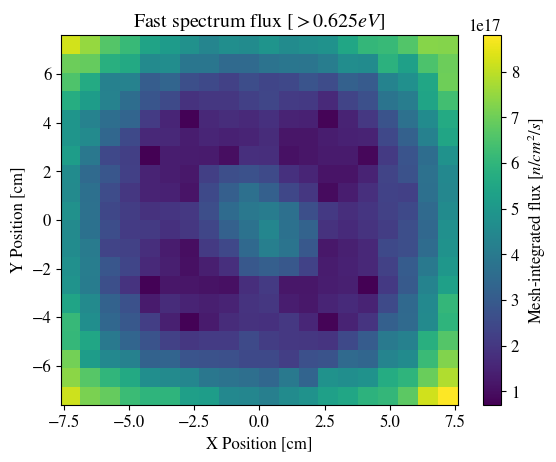

In [20]:
xy.meshPlot('x', 'y', fixed={'energy': 0}, 
                         cbarLabel='Mesh-integrated flux $[n/cm^2/s]$',
                         title="Fast spectrum flux $[>0.625 eV]$");

The `meshPlot` also supports a range of labeling and plot options.
Here, we attempt to plot the flux and U-235 fission reaction rate errors as a function of energy, with
the two reaction rates separated on the y-axis. Passing `logColor=True` applies a logarithmic color scale to all the positive data. Data that is zero is not shown, and errors will be raised if the data contain negative quantities.

Here we also apply custom y-tick labels to reflect the reaction that is being plotted.

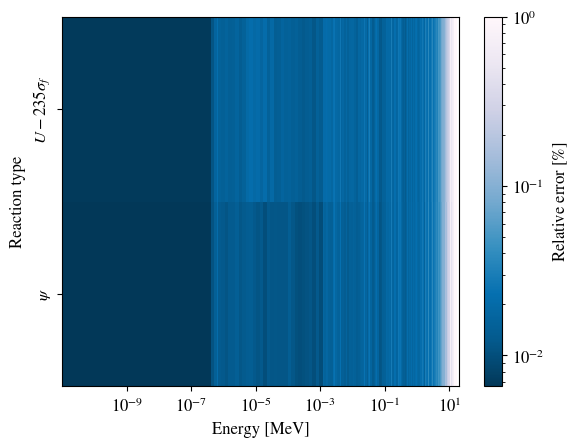

In [21]:
ax = spectrum.meshPlot('e', 'reaction', what='errors', 
                       ylabel='Reaction type', cmap='PuBu_r',
                       cbarLabel="Relative error $[\%]$",
                       xlabel='Energy [MeV]', logColor=True,
                       logx=True);
ax.set_yticks([0.5, 1.5]);
ax.set_yticklabels([r'$\psi$', r'$U-235 \sigma_f$'], rotation=90,
                   verticalalignment='center');

Using the `slicing` arguments allows access to the 1D plot methods from before

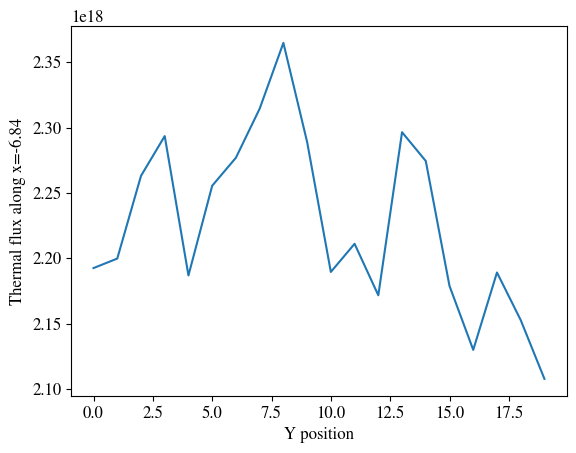

In [22]:
xy.plot(fixed={'energy': 1, 'xmesh': 1}, 
        xlabel='Y position',
        ylabel='Thermal flux along x={}'
        .format(xy.grids['X'][1, 0]));

### Spectrum Plots
The `Detector` objects are also capable of energy spectrum plots, if an associated energy grid is given. The `normalize` option will normalize the data per unit lethargy. This plot takes some additional assumptions with the scaling and labeling, but all the same controls as the above line plots.

The `spectrum` plot method is designed to prepare plots of energy spectra. Supported arguments for the `spectrumPlot` method include

|Option|Default|Description|
|-|-|-|
|`normalize`|`True`|Normalize tallies per unit lethargy|
|`fixed`| `None`|Dictionary that controls matrix reduction|
|`sigma`|3|Level of confidence for statistical errors|
|`xscale`|`'log'`|Set the x scale to be log or linear|
|`yscale`|`'linear'`|Set the y scale to be log or linear|

The figure below demonstrates the default options and control in this `spectrumPlot`  routine by

1. Using the less than helpful plot routine with no formatting
2. Using `spectrumPlot` without normalization to show default labels and scaling
3. Using `spectrumPlot` with normalization

Since our detector has energy bins and reaction bins, we need to reduce down to one-dimension with the `fixed` command.

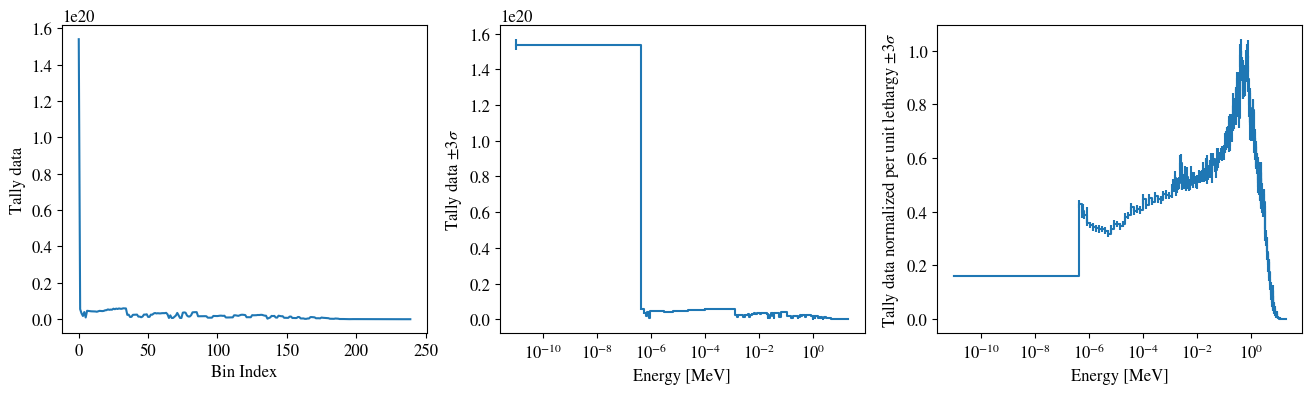

In [23]:
fig, axes = pyplot.subplots(1, 3, figsize=(16, 4))
fix = {'reaction': 0}
spectrum.plot(fixed=fix, ax=axes[0]);
spectrum.spectrumPlot(fixed=fix, ax=axes[1], normalize=False);
spectrum.spectrumPlot(fixed=fix, ax=axes[2]);

### Multiple line plots
Plots can be made against multiple bins, such as spectrum in different materials or reactions, with the ``plot`` and ``spectrumPlot`` 
methods. Below is the flux spectrum and spectrum of the U-235 fission reaction rate from the same detector. The ``labels`` argument is what is used to label each individual plot in the order of the bin index.

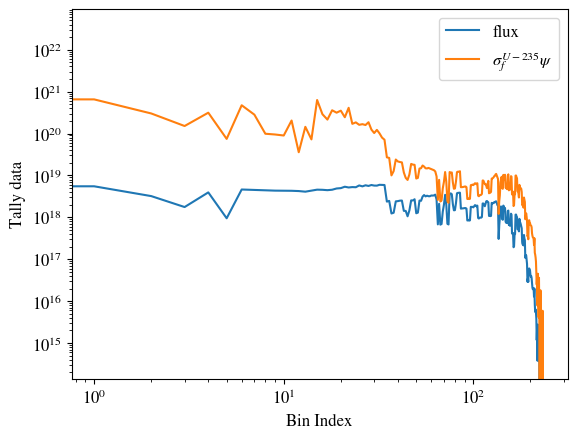

In [24]:
labels = (
    'flux',
    r'$\sigma_f^{U-235}\psi$')  # render as mathtype
spectrum.plot(labels=labels, loglog=True);

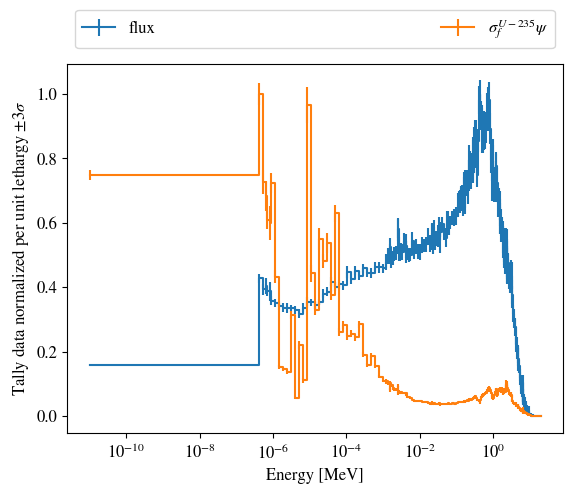

In [25]:
spectrum.spectrumPlot(labels=labels, legend='above', ncol=2);

## Hexagonal Detectors
SERPENT allows the creation of hexagonal detectors with the `dh` card, like
```
det hex2 2 0.0 0.0 1 5 5 0.0 0.0 1
det hex3 3 0.0 0.0 1 5 5 0.0 0.0 1
```
which would create two hexagonal detectors with different orientations. Type 2 detectors have two faces perpendicular to the x-axis, while type 3 detectors have faces perpendicular to the y-axis.
For more information, see the [dh card from SERPENT wiki](http://serpent.vtt.fi/mediawiki/index.php/Input_syntax_manual#det_dh).

`serpentTools` is capable of storing data tallies and grid structures from hexagonal detectors in [`HexagonalDetector`](http://serpent-tools.readthedocs.io/en/latest/api/detectors.html#serpentTools.objects.detectors.HexagonalDetector) objects.

In [26]:
hexFile = 'hexplot_det0.m'
hexR = serpentTools.readDataFile(hexFile)
hexR.detectors

{'hex2': <serpentTools.detectors.HexagonalDetector at 0x7ff372c3db50>,
 'hex3': <serpentTools.detectors.HexagonalDetector at 0x7ff37246c220>}

Here, two `HexagonalDetector` objects are produced, with similar `tallies` and slicing methods as demonstrated above.

In [27]:
hex2 = hexR.detectors['hex2']
hex2.tallies

array([[0.185251, 0.184889, 0.189381, 0.184545, 0.195442],
       [0.181565, 0.186038, 0.193088, 0.195448, 0.195652],
       [0.1856  , 0.190278, 0.192013, 0.193353, 0.184309],
       [0.186249, 0.191939, 0.192513, 0.194196, 0.186953],
       [0.198196, 0.198623, 0.195612, 0.174804, 0.178053]])

In [28]:
hex2.indexes

('ycoord', 'xcoord')

Creating hexagonal mesh plots with these objects requires setting the `pitch` and `hexType` attributes.

In [29]:
hex2.pitch = 1
hex2.hexType = 2

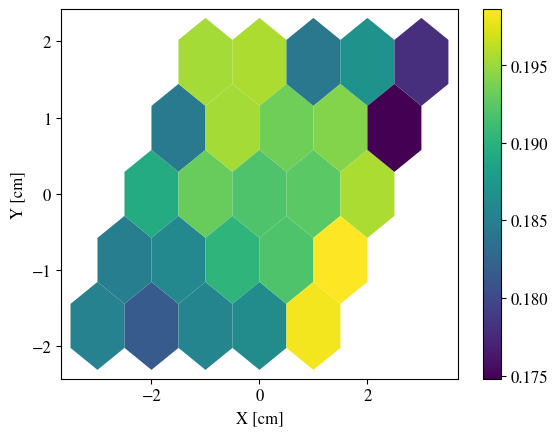

In [30]:
hex2.hexPlot();

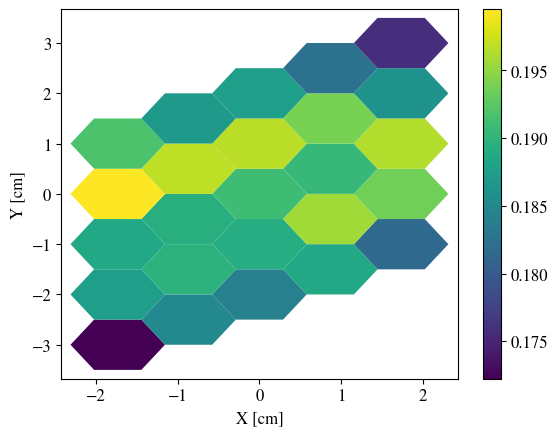

In [31]:
hex3 = hexR.detectors['hex3']
hex3.pitch = 1
hex3.hexType = 3
hex3.hexPlot();

The `thresh` argument can be used to create meshes only above a given value. This works for both Cartesian and hexagonal meshes

## Limitations

`serpentTools` does support reading detector files with hexagonal, cylindrical, and spherical mesh structures. However, creating 2D mesh plots with these detectors, and utilizing their mesh structure, is not fully supported.
[Issue #169](https://github.com/CORE-GATECH-GROUP/serpent-tools/issues/169) is currently tracking progress for cylindrical plotting.

## Conclusion

The `DetectorReader` is capable of reading and storing detector data from SERPENT detector files. The data is stored on custom `Detector` objects, capable of reshaping tally and error matrices into arrays with dimensionality reflecting the detector binning. These `Detector` objects have simple methods for retrieving and plotting detector data.

## References
1. J. Leppänen, M. Pusa, T. Viitanen, V. Valtavirta, and T. Kaltiaisenaho. "The Serpent Monte Carlo code: Status, development and applications in 2013." Ann. Nucl. Energy, [82 (2015) 142-150](https://www.sciencedirect.com/science/article/pii/S0306454914004095)
2. [Matplotlib 2.2.0 Colormaps](https://matplotlib.org/examples/color/colormaps_reference.html)